In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from data_loader import load_innovix_floresland, load_innovix_elbonie, load_bristor_zegoland
from tqdm import tqdm
import shap
from statsmodels.tsa.vector_ar.var_model import VAR
from Forecaster import fill_missing_values_with_gp, Forecaster

DATA_ROOT = "./data"

c:\Users\claud\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_floresland = load_innovix_floresland(DATA_ROOT)
df_elbonie = load_innovix_elbonie(DATA_ROOT)
df_zegoland = load_bristor_zegoland(DATA_ROOT)

In [3]:
df = fill_missing_values_with_gp(df_floresland)

  0%|          | 0/224 [00:00<?, ?it/s]

c:\Users\claud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\claud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\claud\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a b

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import shap
from tqdm import tqdm
from typing import List
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct, Matern
from statsmodels.tsa.vector_ar.var_model import VAR



def fill_missing_values_with_gp(df):
    """
    Fill missing values in the dataframe using Gaussian Processes.
    """
    for col in tqdm(df.columns):
        if df[col].isna().sum() > 0:  # Process columns with missing values
            # Extract observed data
            observed = df[col].dropna()
            X_observed = np.array(observed.index).reshape(-1, 1)  # Reshape index
            y_observed = observed.values

            # Extract missing data locations
            X_missing = np.array(df[df[col].isna()].index).reshape(-1, 1)

            # Define Gaussian Process
            # kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
            PARAM_RANGES = (1e-9, 1e5)

            kernel = WhiteKernel(0.1, PARAM_RANGES)
            kernel += ConstantKernel(1, PARAM_RANGES) * RBF(1, PARAM_RANGES)
            kernel += ConstantKernel(1, PARAM_RANGES) * DotProduct(1, PARAM_RANGES)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

            # Fit GP to observed data
            gp.fit(X_observed, y_observed)

            # Predict missing values
            y_missing_pred, sigma = gp.predict(X_missing, return_std=True)

            # Fill missing values in the original dataframe
            df.loc[df[col].isna(), col] = y_missing_pred
    return df

class ExternalAction:
    def __init__(self, var:str, amount, time, duration, type: str):
        self.var = var
        self.amount = amount
        self.time = time
        self.duration = duration
        self.type = type

        if type not in ["set", "update"]:
            raise Exception()

    def is_applicable(self, time):
        return time >= self.time and time <= self.time + self.duration 

    

class Forecaster:
    def __init__(self):
        # kernel = WhiteKernel(0.1, (1e-3, 1e3))
        # kernel += ConstantKernel(1, (1e-4, 1e2)) * RBF(1, (1e-3, 1e2))
        # kernel += ConstantKernel(1, (1e-4, 1e2)) * ExpSineSquared(1, 1, (1e-2, 1e2), (1e-2, 1e2))
        # kernel += ConstantKernel(1, (1e-4, 1e2)) * DotProduct(1, (1e-2, 1e2))

        PARAM_RANGES = (1e-9, 1e9)
        kernel = WhiteKernel(0.1, PARAM_RANGES)
        kernel += ConstantKernel(1, PARAM_RANGES) * RBF(1, PARAM_RANGES)
        kernel += ConstantKernel(1, PARAM_RANGES) * DotProduct(1, PARAM_RANGES)

        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, random_state=42)
        self.y_mean = None
        self.y_std = None


    def fit(self, df):
        dff = df.set_index(["Date"], drop=False)

        X = dff.drop(columns=["ex_factory_volumes"])
        y = dff["ex_factory_volumes"]

        X = X.fillna(X.mean())

        self.X_mean = X.mean()
        self.X_std = X.std()
        orig_date = X["Date"].copy()
        self.X = (X-self.X_mean)/(self.X_std + 1e-9)
        self.X["Date"] = orig_date

        self.y_mean = y.mean()
        self.y_std = y.std()
        self.y = (y - self.y_mean) / (self.y_std)


    def forecast(self, steps: int, external_actions: List[ExternalAction]=[], maxlags=15, verbose=False):
        stds = []
        preds = []
        start_time = int(self.X.iloc[-1]["Date"]) + 1

        with warnings.catch_warnings(action="ignore"):
            for _ in tqdm(range(steps), disable=not verbose):
                model = VAR(self.X)
                results = model.fit(maxlags=maxlags)

                if not results.is_stable:
                    raise ValueError("Model is unstable. Check data or adjust lags.")

                forecast_input = self.X.values[-results.k_ar:]
                forecast = results.forecast(y=forecast_input, steps=1)
                new_sample = {col: val for col, val in zip(self.X.columns, forecast[0])}
                new_sample["Date"] = start_time

                # Apply feasible actions
                for e in external_actions:
                    if e.is_applicable(start_time):
                        # Apply action
                        if e.type == "set":
                            new_sample[e.var] = e.var
                        elif e.type == "update":
                            # De-normalize
                            new_sample[e.var] = new_sample[e.var] * self.X_std[e.var] + self.X_mean[e.var]
                            new_sample[e.var] *= e.amount
                            # Ri-normalize
                            new_sample[e.var] = (new_sample[e.var] - self.X_mean[e.var]) / self.X_std[e.var]

                self.X = pd.concat([ self.X, pd.DataFrame.from_dict([new_sample]) ])

                start_time += 1

            orig_date = self.X["Date"].copy()
            self.X = self.X * self.X_std + self.X_mean
            self.X["Date"] = orig_date

            self.y = self.y * self.y_std + self.y_mean

            self.gp.fit(self.X.iloc[:len(self.y)], self.y)
            preds, stds = self.gp.predict(self.X.iloc[len(self.y):], return_std=True)
            self.y = pd.concat([ self.y, pd.Series(preds) ])

        return preds, stds

    def explain_with_shap(self, samples, plot_type="bar"):
        
        if self.gp is None or not hasattr(self.gp, "kernel_"):
            raise ValueError("Il modello GP non è stato addestrato. Chiama 'fit' prima di utilizzare SHAP.")

        # Seleziona un sottoinsieme di dati da spiegare
        X_sample = (self.X).sample(n=samples, random_state=42)

        # Crea un Explainer SHAP per GaussianProcessRegressor
        explainer = shap.KernelExplainer(self.gp.predict, X_sample.values)

        # Calcola i valori SHAP
        shap_values = explainer.shap_values(X_sample.values)

        if 'Date' in X_sample.columns:
            date_idx = X_sample.columns.get_loc('Date')
            X_sample = X_sample.drop(columns=["Date"])
            shap_values = np.delete(shap_values, date_idx, axis=1)

        shap_dict = {'X' : [feature for feature in X_sample.columns], 'y' : [float(np.mean(np.abs(shap_values[:, idx]))) for idx in range(len(X_sample.columns))]}
        
        # Visualizza i risultati
        #if plot_type == "bar":
        #    shap.summary_plot(shap_values, X_sample, plot_type="bar")
        #elif plot_type == "summary":
        #    shap.summary_plot(shap_values, X_sample)
        #elif plot_type == "force":
        #    shap.force_plot(explainer.expected_value, shap_values, self.X.iloc[:samples])
        #else:
        #    raise ValueError(f"Tipo di plot SHAP '{plot_type}' non supportato.")

        return shap_dict

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


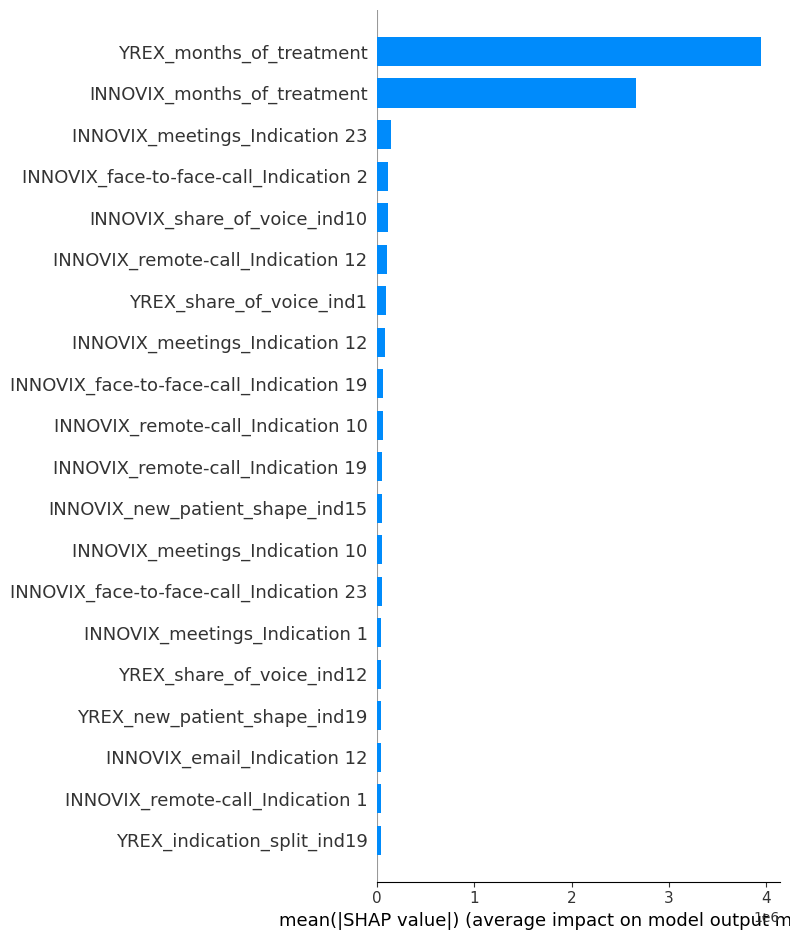

{'X': ['INNOVIX_months_of_treatment', 'YREX_months_of_treatment', 'INNOVIX_face-to-face-call_ind1', 'INNOVIX_face-to-face-call_ind2', 'INNOVIX_face-to-face-call_ind3', 'INNOVIX_face-to-face-call_ind5', 'INNOVIX_face-to-face-call_ind6', 'INNOVIX_face-to-face-call_ind7', 'INNOVIX_face-to-face-call_ind9', 'INNOVIX_face-to-face-call_ind10', 'INNOVIX_face-to-face-call_ind12', 'INNOVIX_face-to-face-call_ind14', 'INNOVIX_face-to-face-call_ind15', 'INNOVIX_face-to-face-call_ind19', 'INNOVIX_face-to-face-call_ind20', 'INNOVIX_face-to-face-call_ind23', 'INNOVIX_email_ind1', 'INNOVIX_email_ind2', 'INNOVIX_email_ind3', 'INNOVIX_email_ind5', 'INNOVIX_email_ind6', 'INNOVIX_email_ind7', 'INNOVIX_email_ind9', 'INNOVIX_email_ind10', 'INNOVIX_email_ind12', 'INNOVIX_email_ind14', 'INNOVIX_email_ind15', 'INNOVIX_email_ind19', 'INNOVIX_email_ind20', 'INNOVIX_email_ind23', 'INNOVIX_remote-call_ind1', 'INNOVIX_remote-call_ind2', 'INNOVIX_remote-call_ind3', 'INNOVIX_remote-call_ind5', 'INNOVIX_remote-call_ind

In [15]:
forecaster = Forecaster()

forecaster.fit(df)

preds, stds = forecaster.forecast(steps=20)

shape_dict = forecaster.explain_with_shap(samples=20, plot_type="bar")
print(shape_dict)
